### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
Time_matrix.shape

(5, 5, 24, 7)

In [4]:
Time_matrix[1][2]

array([[ 5.,  6.,  5.,  7.,  7.,  9.,  7.],
       [ 5.,  6.,  5.,  7.,  7.,  9.,  7.],
       [ 5.,  6.,  5.,  7.,  7.,  9.,  7.],
       [ 5.,  6.,  5.,  7.,  7.,  9.,  7.],
       [ 5.,  6.,  5.,  7.,  7.,  9.,  7.],
       [ 5.,  6.,  5.,  7.,  7.,  9.,  7.],
       [10.,  9.,  4., 10.,  7., 11.,  4.],
       [10.,  9.,  4., 10.,  7., 11.,  4.],
       [10.,  9.,  4., 10.,  7., 11.,  4.],
       [10.,  9.,  4., 10.,  7., 11.,  4.],
       [10.,  9.,  4., 10.,  7., 11.,  4.],
       [10.,  9.,  4., 10.,  7., 11.,  4.],
       [ 1.,  3.,  1.,  1.,  1.,  2.,  2.],
       [ 1.,  3.,  1.,  1.,  1.,  2.,  2.],
       [ 1.,  3.,  1.,  1.,  1.,  2.,  2.],
       [ 1.,  3.,  1.,  1.,  1.,  2.,  2.],
       [ 1.,  3.,  1.,  1.,  1.,  2.,  2.],
       [ 1.,  3.,  1.,  1.,  1.,  2.,  2.],
       [ 5., 11.,  7.,  8., 10.,  6.,  8.],
       [ 5., 11.,  7.,  8., 10.,  6.,  8.],
       [ 5., 11.,  7.,  8., 10.,  6.,  8.],
       [ 5., 11.,  7.,  8., 10.,  6.,  8.],
       [ 5., 11.,  7.,  8., 10.,

#### Tracking the state-action pairs for checking convergence


In [5]:
States_track = collections.defaultdict(dict)
print(len(States_track))

0


In [6]:
def initialise_tracking_states():
    sample_q_values = [((0, 0, 0), (0,1)), ((0, 0, 0), (0,2))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    #The playing agent.
    def __init__(self, state_size, action_size, discount_factor=0.90, learning_rate=0.001,
                 epsilon=1, epsilon_decay=0.0002, epsilon_min=0.00001):
        
        # action and state sizes
        self.state_size = state_size
        self.action_size = action_size

        # parameters
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate   
        self.epsilon_max = epsilon
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = 32    
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1,36)
        
        # build the NN model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets  
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        
        return model


    def get_action(self, state, action_space, possible_actions_index):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            index = random.randrange(len(possible_actions_index))
            action_index = possible_actions_index[index]
            action = action_space[action_index]
            return action_index, action
        else:     
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            return np.argmax(q_value[0]), action_space[np.argmax(q_value[0])]   
             
        
    def append_sample(self, state, action, reward, next_state):     
        # Write your code here:
        # save sample <s,a,r,s'> to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):    
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards = [], []
            
            # populate update_input and update_output and the lists rewards, actions
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                
                # Write your code from here
                # 1. Predict the target from earlier model
                target = self.model.predict(update_input)
                
                # 2. Get the target for the Q-network
                target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # non-terminal state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
        # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def store_q_values(self):
        #We are keeping track of q value for state [0,0,0] and action (0,2)
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])


    def save(self, name):
        self.model.save(name)

In [9]:
Episodes = 5000

### DQN block

In [10]:
import time
start_time = time.time()

# to store rewards in each episode
rewards_per_episode, episodes, avg_rewards_per_episode= [], [], []

env = CabDriver()

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(action_size=len(env.action_space), state_size=len(env.state_encod_arch1(env.state_init)))

for episode in range(Episodes):
    # Write code here
    # Call the environment
    env = CabDriver()  
    # Call all the initialised variables of the environment : reset at the start of each episode
    action_space, state_space, state = env.reset()
    terminal_state = False
    t = 0
    count = 1
    score = 0
    
    while not terminal_state: 
        # Write your code here
        count += 1
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space, possible_actions_index)
        
        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state,action,Time_matrix)
        
        # Evaluate your reward
        reward = env.reward_func(state, action, Time_matrix)
        
        # 3. Append the experience to the memory : save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(env.state_encod_arch1(state), action_index,reward, env.state_encod_arch1(next_state))
        
        # 4. Train the model by calling function agent.train_model:  train after each step
        agent.train_model()
        
        # 5. Keep a track of rewards, Q-values, loss  
        # add reward to the total score of this episode
        score += reward
        state = next_state
        
        # Total time spend
        t += wait_time + transit_time + ride_time
        
        # A terminal state is achieved when the cab completes his 30 days
        if t >= 24 * 30:
            print("state terminated")
            terminal_state = True
    
    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,score,len(agent.memory),agent.epsilon))
    # every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()
    if episode % 1000 == 0:
        # save DQN model 
        agent.save(name="model.pkl")
        elapsed_time = time.time() - start_time
        print('Total time taken ',elapsed_time)     

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

state terminated
episode 0, reward -200.0, memory_length 157, epsilon 1.0
Total time taken  10.475599527359009
state terminated
episode 1, reward 190.0, memory_length 311, epsilon 0.9998000219984667
state terminated
episode 2, reward -149.0, memory_length 476, epsilon 0.9996000839885345
state terminated
episode 3, reward -333.0, memory_length 642, epsilon 0.9994001859622058
state terminated
episode 4, reward -56.0, memory_length 795, epsilon 0.9992003279114846
state terminated
episode 5, reward -195.0, memory_length 952, epsilon 0.9990005098283767
state terminated
episode 6, reward -345.0, memory_length 1103, epsilon 0.9988007317048893
state terminated
episode 7, reward -223.0, memory_length 1253, epsilon 0.9986009935330312
state terminated
episode 8, reward -298.0, memory_length 1386, epsilon 0.9984012953048131
state terminated
episode 9, reward -277.0, memory_length 1527, epsilon 0.998201637012247
state

state terminated
episode 84, reward -237.0, memory_length 2000, epsilon 0.9833404996326909
state terminated
episode 85, reward -406.0, memory_length 2000, epsilon 0.9831438531980633
state terminated
episode 86, reward -307.0, memory_length 2000, epsilon 0.9829472460887899
state terminated
episode 87, reward -146.0, memory_length 2000, epsilon 0.9827506782970066
state terminated
episode 88, reward 8.0, memory_length 2000, epsilon 0.9825541498148506
state terminated
episode 89, reward -544.0, memory_length 2000, epsilon 0.9823576606344606
state terminated
episode 90, reward -99.0, memory_length 2000, epsilon 0.9821612107479771
state terminated
episode 91, reward -308.0, memory_length 2000, epsilon 0.9819648001475423
state terminated
episode 92, reward 31.0, memory_length 2000, epsilon 0.9817684288252996
state terminated
episode 93, reward -90.0, memory_length 2000, epsilon 0.9815720967733942
state terminated
episode 94, reward 112.0, memory_length 2000, epsilon 0.9813758039839727
state t

state terminated
episode 174, reward 36.0, memory_length 2000, epsilon 0.9657988986686473
state terminated
episode 175, reward -211.0, memory_length 2000, epsilon 0.9656057602034039
state terminated
episode 176, reward -226.0, memory_length 2000, epsilon 0.965412660361991
state terminated
episode 177, reward -226.0, memory_length 2000, epsilon 0.9652195991366846
state terminated
episode 178, reward 46.0, memory_length 2000, epsilon 0.9650265765197625
state terminated
episode 179, reward -213.0, memory_length 2000, epsilon 0.9648335925035034
state terminated
episode 180, reward -163.0, memory_length 2000, epsilon 0.9646406470801883
state terminated
episode 181, reward -230.0, memory_length 2000, epsilon 0.964447740242099
state terminated
episode 182, reward -200.0, memory_length 2000, epsilon 0.9642548719815195
state terminated
episode 183, reward 94.0, memory_length 2000, epsilon 0.964062042290735
state terminated
episode 184, reward -1.0, memory_length 2000, epsilon 0.9638692511620324

state terminated
episode 264, reward -72.0, memory_length 2000, epsilon 0.9485702217565849
state terminated
episode 265, reward -235.0, memory_length 2000, epsilon 0.9483805286821734
state terminated
episode 266, reward -17.0, memory_length 2000, epsilon 0.948190873542583
state terminated
episode 267, reward -184.0, memory_length 2000, epsilon 0.9480012563302278
state terminated
episode 268, reward -20.0, memory_length 2000, epsilon 0.947811677037523
state terminated
episode 269, reward -171.0, memory_length 2000, epsilon 0.9476221356568854
state terminated
episode 270, reward 125.0, memory_length 2000, epsilon 0.9474326321807333
state terminated
episode 271, reward -108.0, memory_length 2000, epsilon 0.9472431666014866
state terminated
episode 272, reward 219.0, memory_length 2000, epsilon 0.9470537389115666
state terminated
episode 273, reward 72.0, memory_length 2000, epsilon 0.9468643491033965
state terminated
episode 274, reward -9.0, memory_length 2000, epsilon 0.9466749971694004

state terminated
episode 355, reward -13.0, memory_length 2000, epsilon 0.9314625775086708
state terminated
episode 356, reward 41.0, memory_length 2000, epsilon 0.9312763056209787
state terminated
episode 357, reward 295.0, memory_length 2000, epsilon 0.931090070983939
state terminated
episode 358, reward -147.0, memory_length 2000, epsilon 0.9309038735901023
state terminated
episode 359, reward 208.0, memory_length 2000, epsilon 0.9307177134320206
state terminated
episode 360, reward -288.0, memory_length 2000, epsilon 0.9305315905022477
state terminated
episode 361, reward -105.0, memory_length 2000, epsilon 0.9303455047933383
state terminated
episode 362, reward 148.0, memory_length 2000, epsilon 0.9301594562978494
state terminated
episode 363, reward -69.0, memory_length 2000, epsilon 0.9299734450083388
state terminated
episode 364, reward -81.0, memory_length 2000, epsilon 0.9297874709173661
state terminated
episode 365, reward -90.0, memory_length 2000, epsilon 0.929601534017492

state terminated
episode 446, reward -182.0, memory_length 2000, epsilon 0.9146634761292013
state terminated
episode 447, reward 136.0, memory_length 2000, epsilon 0.9144805637258255
state terminated
episode 448, reward 130.0, memory_length 2000, epsilon 0.9142976879012723
state terminated
episode 449, reward -140.0, memory_length 2000, epsilon 0.9141148486482269
state terminated
episode 450, reward 387.0, memory_length 2000, epsilon 0.9139320459593755
state terminated
episode 451, reward 282.0, memory_length 2000, epsilon 0.913749279827406
state terminated
episode 452, reward -89.0, memory_length 2000, epsilon 0.9135665502450079
state terminated
episode 453, reward 66.0, memory_length 2000, epsilon 0.9133838572048719
state terminated
episode 454, reward 99.0, memory_length 2000, epsilon 0.9132012006996902
state terminated
episode 455, reward 63.0, memory_length 2000, epsilon 0.9130185807221568
state terminated
episode 456, reward 94.0, memory_length 2000, epsilon 0.9128359972649667
st

state terminated
episode 537, reward 92.0, memory_length 2000, epsilon 0.8981673529302341
state terminated
episode 538, reward 468.0, memory_length 2000, epsilon 0.8979877394215975
state terminated
episode 539, reward 220.0, memory_length 2000, epsilon 0.8978081618320708
state terminated
episode 540, reward 321.0, memory_length 2000, epsilon 0.8976286201544705
state terminated
episode 541, reward 16.0, memory_length 2000, epsilon 0.8974491143816153
state terminated
episode 542, reward 262.0, memory_length 2000, epsilon 0.8972696445063247
state terminated
episode 543, reward 228.0, memory_length 2000, epsilon 0.8970902105214201
state terminated
episode 544, reward 143.0, memory_length 2000, epsilon 0.896910812419724
state terminated
episode 545, reward -198.0, memory_length 2000, epsilon 0.8967314501940604
state terminated
episode 546, reward 133.0, memory_length 2000, epsilon 0.896552123837255
state terminated
episode 547, reward -108.0, memory_length 2000, epsilon 0.8963728333421348
s

state terminated
episode 628, reward -93.0, memory_length 2000, epsilon 0.8819687435850894
state terminated
episode 629, reward 6.0, memory_length 2000, epsilon 0.8817923694743713
state terminated
episode 630, reward 387.0, memory_length 2000, epsilon 0.8816160306349482
state terminated
episode 631, reward 189.0, memory_length 2000, epsilon 0.8814397270597664
state terminated
episode 632, reward 258.0, memory_length 2000, epsilon 0.8812634587417738
state terminated
episode 633, reward -123.0, memory_length 2000, epsilon 0.8810872256739197
state terminated
episode 634, reward 610.0, memory_length 2000, epsilon 0.8809110278491548
state terminated
episode 635, reward 4.0, memory_length 2000, epsilon 0.880734865260431
state terminated
episode 636, reward 245.0, memory_length 2000, epsilon 0.8805587379007019
state terminated
episode 637, reward 205.0, memory_length 2000, epsilon 0.8803826457629226
state terminated
episode 638, reward 298.0, memory_length 2000, epsilon 0.8802065888400491
sta

state terminated
episode 719, reward 85.0, memory_length 2000, epsilon 0.8660622823182971
state terminated
episode 720, reward 124.0, memory_length 2000, epsilon 0.8658890891817244
state terminated
episode 721, reward 136.0, memory_length 2000, epsilon 0.8657159306803154
state terminated
episode 722, reward 284.0, memory_length 2000, epsilon 0.8655428068071438
state terminated
episode 723, reward 335.0, memory_length 2000, epsilon 0.8653697175552845
state terminated
episode 724, reward 117.0, memory_length 2000, epsilon 0.8651966629178139
state terminated
episode 725, reward 286.0, memory_length 2000, epsilon 0.8650236428878102
state terminated
episode 726, reward 172.0, memory_length 2000, epsilon 0.8648506574583522
state terminated
episode 727, reward 143.0, memory_length 2000, epsilon 0.8646777066225205
state terminated
episode 728, reward 354.0, memory_length 2000, epsilon 0.8645047903733973
state terminated
episode 729, reward 173.0, memory_length 2000, epsilon 0.8643319087040658


state terminated
episode 810, reward 268.0, memory_length 2000, epsilon 0.8504427001281876
state terminated
episode 811, reward 366.0, memory_length 2000, epsilon 0.8502726305956821
state terminated
episode 812, reward 217.0, memory_length 2000, epsilon 0.8501025950736819
state terminated
episode 813, reward 870.0, memory_length 2000, epsilon 0.8499325935553858
state terminated
episode 814, reward 462.0, memory_length 2000, epsilon 0.8497626260339933
state terminated
episode 815, reward 453.0, memory_length 2000, epsilon 0.8495926925027061
state terminated
episode 816, reward 184.0, memory_length 2000, epsilon 0.8494227929547267
state terminated
episode 817, reward 522.0, memory_length 2000, epsilon 0.8492529273832591
state terminated
episode 818, reward 311.0, memory_length 2000, epsilon 0.8490830957815088
state terminated
episode 819, reward 324.0, memory_length 2000, epsilon 0.8489132981426823
state terminated
episode 820, reward 357.0, memory_length 2000, epsilon 0.848743534459988


state terminated
episode 901, reward 39.0, memory_length 2000, epsilon 0.8351048230415397
state terminated
episode 902, reward 250.0, memory_length 2000, epsilon 0.8349378207777144
state terminated
episode 903, reward 471.0, memory_length 2000, epsilon 0.8347708519110021
state terminated
episode 904, reward 646.0, memory_length 2000, epsilon 0.8346039164347239
state terminated
episode 905, reward 234.0, memory_length 2000, epsilon 0.8344370143422026
state terminated
episode 906, reward 162.0, memory_length 2000, epsilon 0.8342701456267619
state terminated
episode 907, reward 283.0, memory_length 2000, epsilon 0.8341033102817272
state terminated
episode 908, reward 691.0, memory_length 2000, epsilon 0.833936508300425
state terminated
episode 909, reward 160.0, memory_length 2000, epsilon 0.8337697396761832
state terminated
episode 910, reward 319.0, memory_length 2000, epsilon 0.8336030044023311
state terminated
episode 911, reward 340.0, memory_length 2000, epsilon 0.8334363024721994
s

state terminated
episode 992, reward 593.0, memory_length 2000, epsilon 0.8200435703997062
state terminated
episode 993, reward 171.0, memory_length 2000, epsilon 0.8198795800852043
state terminated
episode 994, reward -42.0, memory_length 2000, epsilon 0.8197156225654858
state terminated
episode 995, reward 296.0, memory_length 2000, epsilon 0.8195516978339923
state terminated
episode 996, reward 326.0, memory_length 2000, epsilon 0.8193878058841668
state terminated
episode 997, reward 223.0, memory_length 2000, epsilon 0.8192239467094536
state terminated
episode 998, reward 629.0, memory_length 2000, epsilon 0.8190601203032984
state terminated
episode 999, reward 261.0, memory_length 2000, epsilon 0.8188963266591482
state terminated
episode 1000, reward 283.0, memory_length 2000, epsilon 0.8187325657704511
Total time taken  6562.746367931366
state terminated
episode 1001, reward 499.0, memory_length 2000, epsilon 0.8185688376306567
state terminated
episode 1002, reward 305.0, memory_

state terminated
episode 1081, reward 69.0, memory_length 2000, epsilon 0.8055761151850275
state terminated
episode 1082, reward 389.0, memory_length 2000, epsilon 0.8054150180722387
state terminated
episode 1083, reward 494.0, memory_length 2000, epsilon 0.8052539531756508
state terminated
episode 1084, reward 642.0, memory_length 2000, epsilon 0.8050929204888212
state terminated
episode 1085, reward 370.0, memory_length 2000, epsilon 0.8049319200053084
state terminated
episode 1086, reward 432.0, memory_length 2000, epsilon 0.8047709517186725
state terminated
episode 1087, reward 406.0, memory_length 2000, epsilon 0.8046100156224749
state terminated
episode 1088, reward 369.0, memory_length 2000, epsilon 0.804449111710278
state terminated
episode 1089, reward 492.0, memory_length 2000, epsilon 0.8042882399756457
state terminated
episode 1090, reward 397.0, memory_length 2000, epsilon 0.8041274004121429
state terminated
episode 1091, reward 653.0, memory_length 2000, epsilon 0.8039665

state terminated
episode 1171, reward 799.0, memory_length 2000, epsilon 0.7912056473229924
state terminated
episode 1172, reward 849.0, memory_length 2000, epsilon 0.7910474240163858
state terminated
episode 1173, reward 835.0, memory_length 2000, epsilon 0.7908892323512764
state terminated
episode 1174, reward 443.0, memory_length 2000, epsilon 0.7907310723213363
state terminated
episode 1175, reward 508.0, memory_length 2000, epsilon 0.7905729439202392
state terminated
episode 1176, reward 508.0, memory_length 2000, epsilon 0.7904148471416601
state terminated
episode 1177, reward 504.0, memory_length 2000, epsilon 0.7902567819792748
state terminated
episode 1178, reward 286.0, memory_length 2000, epsilon 0.790098748426761
state terminated
episode 1179, reward 57.0, memory_length 2000, epsilon 0.7899407464777972
state terminated
episode 1180, reward 711.0, memory_length 2000, epsilon 0.7897827761260634
state terminated
episode 1181, reward 281.0, memory_length 2000, epsilon 0.7896248

state terminated
episode 1261, reward 904.0, memory_length 2000, epsilon 0.7770915337721441
state terminated
episode 1262, reward 294.0, memory_length 2000, epsilon 0.7769361330059843
state terminated
episode 1263, reward 533.0, memory_length 2000, epsilon 0.77678076331687
state terminated
episode 1264, reward 468.0, memory_length 2000, epsilon 0.7766254246985863
state terminated
episode 1265, reward 472.0, memory_length 2000, epsilon 0.7764701171449195
state terminated
episode 1266, reward 918.0, memory_length 2000, epsilon 0.7763148406496577
state terminated
episode 1267, reward 638.0, memory_length 2000, epsilon 0.7761595952065896
state terminated
episode 1268, reward 476.0, memory_length 2000, epsilon 0.7760043808095054
state terminated
episode 1269, reward 739.0, memory_length 2000, epsilon 0.7758491974521965
state terminated
episode 1270, reward 757.0, memory_length 2000, epsilon 0.7756940451284555
state terminated
episode 1271, reward 502.0, memory_length 2000, epsilon 0.7755389

state terminated
episode 1351, reward 588.0, memory_length 2000, epsilon 0.7632292014362209
state terminated
episode 1352, reward 754.0, memory_length 2000, epsilon 0.7630765728593
state terminated
episode 1353, reward 395.0, memory_length 2000, epsilon 0.7629239748050424
state terminated
episode 1354, reward 620.0, memory_length 2000, epsilon 0.7627714072673436
state terminated
episode 1355, reward 854.0, memory_length 2000, epsilon 0.7626188702401013
state terminated
episode 1356, reward 760.0, memory_length 2000, epsilon 0.7624663637172139
state terminated
episode 1357, reward 540.0, memory_length 2000, epsilon 0.7623138876925812
state terminated
episode 1358, reward 832.0, memory_length 2000, epsilon 0.7621614421601041
state terminated
episode 1359, reward 831.0, memory_length 2000, epsilon 0.7620090271136848
state terminated
episode 1360, reward 535.0, memory_length 2000, epsilon 0.7618566425472266
state terminated
episode 1361, reward 265.0, memory_length 2000, epsilon 0.76170428

state terminated
episode 1441, reward 410.0, memory_length 2000, epsilon 0.7496141587982765
state terminated
episode 1442, reward 459.0, memory_length 2000, epsilon 0.7494642529576007
state terminated
episode 1443, reward 540.0, memory_length 2000, epsilon 0.749314377095095
state terminated
episode 1444, reward 657.0, memory_length 2000, epsilon 0.7491645312047645
state terminated
episode 1445, reward 574.0, memory_length 2000, epsilon 0.7490147152806153
state terminated
episode 1446, reward 569.0, memory_length 2000, epsilon 0.7488649293166549
state terminated
episode 1447, reward 421.0, memory_length 2000, epsilon 0.7487151733068917
state terminated
episode 1448, reward 495.0, memory_length 2000, epsilon 0.7485654472453356
state terminated
episode 1449, reward 602.0, memory_length 2000, epsilon 0.7484157511259975
state terminated
episode 1450, reward 867.0, memory_length 2000, epsilon 0.7482660849428894
state terminated
episode 1451, reward 577.0, memory_length 2000, epsilon 0.748116

state terminated
episode 1531, reward 644.0, memory_length 2000, epsilon 0.7362419944653908
state terminated
episode 1532, reward 786.0, memory_length 2000, epsilon 0.7360947627901561
state terminated
episode 1533, reward 703.0, memory_length 2000, epsilon 0.7359475605583119
state terminated
episode 1534, reward 272.0, memory_length 2000, epsilon 0.7358003877639702
state terminated
episode 1535, reward 659.0, memory_length 2000, epsilon 0.7356532444012442
state terminated
episode 1536, reward 848.0, memory_length 2000, epsilon 0.7355061304642481
state terminated
episode 1537, reward 731.0, memory_length 2000, epsilon 0.7353590459470972
state terminated
episode 1538, reward 540.0, memory_length 2000, epsilon 0.7352119908439082
state terminated
episode 1539, reward 524.0, memory_length 2000, epsilon 0.735064965148799
state terminated
episode 1540, reward 495.0, memory_length 2000, epsilon 0.7349179688558887
state terminated
episode 1541, reward 100.0, memory_length 2000, epsilon 0.734771

state terminated
episode 1621, reward 891.0, memory_length 2000, epsilon 0.7231083757393391
state terminated
episode 1622, reward 855.0, memory_length 2000, epsilon 0.7229637705251946
state terminated
episode 1623, reward 1020.0, memory_length 2000, epsilon 0.722819194229201
state terminated
episode 1624, reward 1205.0, memory_length 2000, epsilon 0.7226746468455754
state terminated
episode 1625, reward 515.0, memory_length 2000, epsilon 0.7225301283685358
state terminated
episode 1626, reward 720.0, memory_length 2000, epsilon 0.7223856387923013
state terminated
episode 1627, reward 661.0, memory_length 2000, epsilon 0.7222411781110925
state terminated
episode 1628, reward 882.0, memory_length 2000, epsilon 0.7220967463191309
state terminated
episode 1629, reward 724.0, memory_length 2000, epsilon 0.7219523434106393
state terminated
episode 1630, reward 405.0, memory_length 2000, epsilon 0.7218079693798415
state terminated
episode 1631, reward 522.0, memory_length 2000, epsilon 0.7216

state terminated
episode 1711, reward 887.0, memory_length 2000, epsilon 0.7102090472127597
state terminated
episode 1712, reward 1041.0, memory_length 2000, epsilon 0.7100670216063512
state terminated
episode 1713, reward 606.0, memory_length 2000, epsilon 0.7099250244022236
state terminated
episode 1714, reward 1093.0, memory_length 2000, epsilon 0.7097830555946971
state terminated
episode 1715, reward 704.0, memory_length 2000, epsilon 0.709641115178093
state terminated
episode 1716, reward 1307.0, memory_length 2000, epsilon 0.7094992031467336
state terminated
episode 1717, reward 871.0, memory_length 2000, epsilon 0.7093573194949424
state terminated
episode 1718, reward 312.0, memory_length 2000, epsilon 0.7092154642170441
state terminated
episode 1719, reward 618.0, memory_length 2000, epsilon 0.7090736373073644
state terminated
episode 1720, reward 684.0, memory_length 2000, epsilon 0.7089318387602301
state terminated
episode 1721, reward 1135.0, memory_length 2000, epsilon 0.70

state terminated
episode 1800, reward 427.0, memory_length 2000, epsilon 0.6976793493077703
state terminated
episode 1801, reward 768.0, memory_length 2000, epsilon 0.6975398293903656
state terminated
episode 1802, reward 519.0, memory_length 2000, epsilon 0.6974003373741541
state terminated
episode 1803, reward 846.0, memory_length 2000, epsilon 0.6972608732535562
state terminated
episode 1804, reward 889.0, memory_length 2000, epsilon 0.6971214370229933
state terminated
episode 1805, reward 970.0, memory_length 2000, epsilon 0.6969820286768881
state terminated
episode 1806, reward 723.0, memory_length 2000, epsilon 0.696842648209664
state terminated
episode 1807, reward 854.0, memory_length 2000, epsilon 0.696703295615746
state terminated
episode 1808, reward 943.0, memory_length 2000, epsilon 0.6965639708895598
state terminated
episode 1809, reward 903.0, memory_length 2000, epsilon 0.6964246740255327
state terminated
episode 1810, reward 751.0, memory_length 2000, epsilon 0.6962854

state terminated
episode 1890, reward 833.0, memory_length 2000, epsilon 0.6852336483608636
state terminated
episode 1891, reward 845.0, memory_length 2000, epsilon 0.6850966173347508
state terminated
episode 1892, reward 657.0, memory_length 2000, epsilon 0.6849596137121029
state terminated
episode 1893, reward 724.0, memory_length 2000, epsilon 0.6848226374874395
state terminated
episode 1894, reward 466.0, memory_length 2000, epsilon 0.6846856886552817
state terminated
episode 1895, reward 701.0, memory_length 2000, epsilon 0.6845487672101516
state terminated
episode 1896, reward 980.0, memory_length 2000, epsilon 0.6844118731465721
state terminated
episode 1897, reward 762.0, memory_length 2000, epsilon 0.6842750064590679
state terminated
episode 1898, reward 571.0, memory_length 2000, epsilon 0.6841381671421639
state terminated
episode 1899, reward 735.0, memory_length 2000, epsilon 0.6840013551903866
state terminated
episode 1900, reward 716.0, memory_length 2000, epsilon 0.68386

state terminated
episode 1979, reward 1116.0, memory_length 2000, epsilon 0.6731445793244978
state terminated
episode 1980, reward 738.0, memory_length 2000, epsilon 0.6730099658704269
state terminated
episode 1981, reward 541.0, memory_length 2000, epsilon 0.672875379336355
state terminated
episode 1982, reward 792.0, memory_length 2000, epsilon 0.6727408197168981
state terminated
episode 1983, reward 1004.0, memory_length 2000, epsilon 0.6726062870066744
state terminated
episode 1984, reward 958.0, memory_length 2000, epsilon 0.6724717812003019
state terminated
episode 1985, reward 936.0, memory_length 2000, epsilon 0.6723373022924009
state terminated
episode 1986, reward 643.0, memory_length 2000, epsilon 0.6722028502775921
state terminated
episode 1987, reward 830.0, memory_length 2000, epsilon 0.6720684251504974
state terminated
episode 1988, reward 1212.0, memory_length 2000, epsilon 0.6719340269057398
state terminated
episode 1989, reward 1425.0, memory_length 2000, epsilon 0.67

state terminated
episode 2068, reward 1234.0, memory_length 2000, epsilon 0.6612687918795009
state terminated
episode 2069, reward 975.0, memory_length 2000, epsilon 0.6611365533454193
state terminated
episode 2070, reward 918.0, memory_length 2000, epsilon 0.6610043412563997
state terminated
episode 2071, reward 1035.0, memory_length 2000, epsilon 0.6608721556071541
state terminated
episode 2072, reward 1043.0, memory_length 2000, epsilon 0.6607399963923947
state terminated
episode 2073, reward 435.0, memory_length 2000, epsilon 0.6606078636068351
state terminated
episode 2074, reward 1110.0, memory_length 2000, epsilon 0.6604757572451903
state terminated
episode 2075, reward 1195.0, memory_length 2000, epsilon 0.6603436773021758
state terminated
episode 2076, reward 1142.0, memory_length 2000, epsilon 0.6602116237725085
state terminated
episode 2077, reward 1125.0, memory_length 2000, epsilon 0.6600795966509062
state terminated
episode 2078, reward 584.0, memory_length 2000, epsilon 

state terminated
episode 2157, reward 969.0, memory_length 2000, epsilon 0.6496025232020294
state terminated
episode 2158, reward 1102.0, memory_length 2000, epsilon 0.6494726176883733
state terminated
episode 2159, reward 641.0, memory_length 2000, epsilon 0.6493427381532222
state terminated
episode 2160, reward 1296.0, memory_length 2000, epsilon 0.6492128845913806
state terminated
episode 2161, reward 1098.0, memory_length 2000, epsilon 0.6490830569976543
state terminated
episode 2162, reward 868.0, memory_length 2000, epsilon 0.6489532553668506
state terminated
episode 2163, reward 1344.0, memory_length 2000, epsilon 0.6488234796937772
state terminated
episode 2164, reward 1178.0, memory_length 2000, epsilon 0.6486937299732429
state terminated
episode 2165, reward 565.0, memory_length 2000, epsilon 0.648564006200058
state terminated
episode 2166, reward 1471.0, memory_length 2000, epsilon 0.6484343083690335
state terminated
episode 2167, reward 1043.0, memory_length 2000, epsilon 0

state terminated
episode 2246, reward 936.0, memory_length 2000, epsilon 0.6381420768539187
state terminated
episode 2247, reward 1291.0, memory_length 2000, epsilon 0.6380144632003386
state terminated
episode 2248, reward 794.0, memory_length 2000, epsilon 0.6378868750669372
state terminated
episode 2249, reward 913.0, memory_length 2000, epsilon 0.6377593124486108
state terminated
episode 2250, reward 1047.0, memory_length 2000, epsilon 0.6376317753402571
state terminated
episode 2251, reward 967.0, memory_length 2000, epsilon 0.6375042637367743
state terminated
episode 2252, reward 409.0, memory_length 2000, epsilon 0.6373767776330624
state terminated
episode 2253, reward 895.0, memory_length 2000, epsilon 0.6372493170240214
state terminated
episode 2254, reward 1129.0, memory_length 2000, epsilon 0.6371218819045534
state terminated
episode 2255, reward 720.0, memory_length 2000, epsilon 0.6369944722695607
state terminated
episode 2256, reward 1309.0, memory_length 2000, epsilon 0.6

state terminated
episode 2335, reward 1277.0, memory_length 2000, epsilon 0.6268838216114729
state terminated
episode 2336, reward 1160.0, memory_length 2000, epsilon 0.6267584593837913
state terminated
episode 2337, reward 1271.0, memory_length 2000, epsilon 0.6266331222260481
state terminated
episode 2338, reward 722.0, memory_length 2000, epsilon 0.6265078101332298
state terminated
episode 2339, reward 745.0, memory_length 2000, epsilon 0.626382523100324
state terminated
episode 2340, reward 647.0, memory_length 2000, epsilon 0.6262572611223194
state terminated
episode 2341, reward 924.0, memory_length 2000, epsilon 0.6261320241942051
state terminated
episode 2342, reward 902.0, memory_length 2000, epsilon 0.626006812310972
state terminated
episode 2343, reward 993.0, memory_length 2000, epsilon 0.6258816254676115
state terminated
episode 2344, reward 1128.0, memory_length 2000, epsilon 0.625756463659116
state terminated
episode 2345, reward 1188.0, memory_length 2000, epsilon 0.625

state terminated
episode 2424, reward 1356.0, memory_length 2000, epsilon 0.6158241903149176
state terminated
episode 2425, reward 1492.0, memory_length 2000, epsilon 0.6157010397923175
state terminated
episode 2426, reward 1300.0, memory_length 2000, epsilon 0.6155779138973588
state terminated
episode 2427, reward 1008.0, memory_length 2000, epsilon 0.6154548126251169
state terminated
episode 2428, reward 997.0, memory_length 2000, epsilon 0.6153317359706677
state terminated
episode 2429, reward 1197.0, memory_length 2000, epsilon 0.6152086839290879
state terminated
episode 2430, reward 674.0, memory_length 2000, epsilon 0.6150856564954555
state terminated
episode 2431, reward 876.0, memory_length 2000, epsilon 0.6149626536648495
state terminated
episode 2432, reward 1042.0, memory_length 2000, epsilon 0.6148396754323497
state terminated
episode 2433, reward 926.0, memory_length 2000, epsilon 0.6147167217930369
state terminated
episode 2434, reward 604.0, memory_length 2000, epsilon 0

state terminated
episode 2513, reward 1494.0, memory_length 2000, epsilon 0.6049596787381513
state terminated
episode 2514, reward 826.0, memory_length 2000, epsilon 0.6048387009005907
state terminated
episode 2515, reward 979.0, memory_length 2000, epsilon 0.6047177472561781
state terminated
episode 2516, reward 1660.0, memory_length 2000, epsilon 0.6045968178000756
state terminated
episode 2517, reward 1151.0, memory_length 2000, epsilon 0.6044759125274458
state terminated
episode 2518, reward 979.0, memory_length 2000, epsilon 0.6043550314334527
state terminated
episode 2519, reward 1207.0, memory_length 2000, epsilon 0.6042341745132608
state terminated
episode 2520, reward 1326.0, memory_length 2000, epsilon 0.6041133417620361
state terminated
episode 2521, reward 1179.0, memory_length 2000, epsilon 0.6039925331749452
state terminated
episode 2522, reward 1124.0, memory_length 2000, epsilon 0.6038717487471555
state terminated
episode 2523, reward 1197.0, memory_length 2000, epsilon

state terminated
episode 2602, reward 1214.0, memory_length 2000, epsilon 0.5942868444784362
state terminated
episode 2603, reward 1203.0, memory_length 2000, epsilon 0.5941680009942849
state terminated
episode 2604, reward 1141.0, memory_length 2000, epsilon 0.5940491812764539
state terminated
episode 2605, reward 1503.0, memory_length 2000, epsilon 0.5939303853201903
state terminated
episode 2606, reward 1351.0, memory_length 2000, epsilon 0.593811613120742
state terminated
episode 2607, reward 1169.0, memory_length 2000, epsilon 0.5936928646733586
state terminated
episode 2608, reward 1406.0, memory_length 2000, epsilon 0.5935741399732896
state terminated
episode 2609, reward 1140.0, memory_length 2000, epsilon 0.5934554390157863
state terminated
episode 2610, reward 993.0, memory_length 2000, epsilon 0.5933367617961007
state terminated
episode 2611, reward 1395.0, memory_length 2000, epsilon 0.5932181083094857
state terminated
episode 2612, reward 1365.0, memory_length 2000, epsilo

state terminated
episode 2691, reward 1222.0, memory_length 2000, epsilon 0.5838023058656794
state terminated
episode 2692, reward 1417.0, memory_length 2000, epsilon 0.5836855590795741
state terminated
episode 2693, reward 972.0, memory_length 2000, epsilon 0.5835688356404911
state terminated
episode 2694, reward 1527.0, memory_length 2000, epsilon 0.5834521355437616
state terminated
episode 2695, reward 1296.0, memory_length 2000, epsilon 0.5833354587847178
state terminated
episode 2696, reward 1138.0, memory_length 2000, epsilon 0.5832188053586923
state terminated
episode 2697, reward 706.0, memory_length 2000, epsilon 0.5831021752610192
state terminated
episode 2698, reward 809.0, memory_length 2000, epsilon 0.582985568487033
state terminated
episode 2699, reward 1194.0, memory_length 2000, epsilon 0.5828689850320696
state terminated
episode 2700, reward 1007.0, memory_length 2000, epsilon 0.5827524248914658
state terminated
episode 2701, reward 1044.0, memory_length 2000, epsilon 

state terminated
episode 2780, reward 639.0, memory_length 2000, epsilon 0.5735027408909565
state terminated
episode 2781, reward 1532.0, memory_length 2000, epsilon 0.5733880538118685
state terminated
episode 2782, reward 1080.0, memory_length 2000, epsilon 0.5732733896679028
state terminated
episode 2783, reward 1171.0, memory_length 2000, epsilon 0.5731587484544728
state terminated
episode 2784, reward 1300.0, memory_length 2000, epsilon 0.5730441301669926
state terminated
episode 2785, reward 1447.0, memory_length 2000, epsilon 0.5729295348008778
state terminated
episode 2786, reward 1039.0, memory_length 2000, epsilon 0.5728149623515445
state terminated
episode 2787, reward 1333.0, memory_length 2000, epsilon 0.5727004128144098
state terminated
episode 2788, reward 1232.0, memory_length 2000, epsilon 0.5725858861848916
state terminated
episode 2789, reward 1455.0, memory_length 2000, epsilon 0.5724713824584089
state terminated
episode 2790, reward 1133.0, memory_length 2000, epsil

state terminated
episode 2869, reward 1710.0, memory_length 2000, epsilon 0.5633848861539376
state terminated
episode 2870, reward 1267.0, memory_length 2000, epsilon 0.5632722224434533
state terminated
episode 2871, reward 1244.0, memory_length 2000, epsilon 0.5631595812634581
state terminated
episode 2872, reward 1140.0, memory_length 2000, epsilon 0.5630469626094462
state terminated
episode 2873, reward 1623.0, memory_length 2000, epsilon 0.562934366476913
state terminated
episode 2874, reward 1512.0, memory_length 2000, epsilon 0.5628217928613544
state terminated
episode 2875, reward 1173.0, memory_length 2000, epsilon 0.5627092417582676
state terminated
episode 2876, reward 1012.0, memory_length 2000, epsilon 0.5625967131631505
state terminated
episode 2877, reward 1148.0, memory_length 2000, epsilon 0.5624842070715022
state terminated
episode 2878, reward 891.0, memory_length 2000, epsilon 0.562371723478822
state terminated
episode 2879, reward 1043.0, memory_length 2000, epsilon

state terminated
episode 2958, reward 1312.0, memory_length 2000, epsilon 0.5534455358288844
state terminated
episode 2959, reward 1298.0, memory_length 2000, epsilon 0.5533348597896914
state terminated
episode 2960, reward 1206.0, memory_length 2000, epsilon 0.553224205883493
state terminated
episode 2961, reward 1345.0, memory_length 2000, epsilon 0.5531135741058628
state terminated
episode 2962, reward 1251.0, memory_length 2000, epsilon 0.5530029644523757
state terminated
episode 2963, reward 1431.0, memory_length 2000, epsilon 0.5528923769186073
state terminated
episode 2964, reward 1390.0, memory_length 2000, epsilon 0.552781811500134
state terminated
episode 2965, reward 1470.0, memory_length 2000, epsilon 0.5526712681925331
state terminated
episode 2966, reward 1622.0, memory_length 2000, epsilon 0.5525607469913831
state terminated
episode 2967, reward 1282.0, memory_length 2000, epsilon 0.552450247892263
state terminated
episode 2968, reward 1204.0, memory_length 2000, epsilon

state terminated
episode 3046, reward 1563.0, memory_length 2000, epsilon 0.5437902858311758
state terminated
episode 3047, reward 1397.0, memory_length 2000, epsilon 0.5436815406488903
state terminated
episode 3048, reward 1048.0, memory_length 2000, epsilon 0.5435728172134664
state terminated
episode 3049, reward 1406.0, memory_length 2000, epsilon 0.5434641155205554
state terminated
episode 3050, reward 1434.0, memory_length 2000, epsilon 0.543355435565809
state terminated
episode 3051, reward 1370.0, memory_length 2000, epsilon 0.5432467773448801
state terminated
episode 3052, reward 1364.0, memory_length 2000, epsilon 0.5431381408534225
state terminated
episode 3053, reward 1291.0, memory_length 2000, epsilon 0.5430295260870904
state terminated
episode 3054, reward 1272.0, memory_length 2000, epsilon 0.5429209330415395
state terminated
episode 3055, reward 918.0, memory_length 2000, epsilon 0.5428123617124261
state terminated
episode 3056, reward 1376.0, memory_length 2000, epsilo

state terminated
episode 3135, reward 1411.0, memory_length 2000, epsilon 0.5341966335517294
state terminated
episode 3136, reward 1238.0, memory_length 2000, epsilon 0.5340898069080395
state terminated
episode 3137, reward 1268.0, memory_length 2000, epsilon 0.5339830016275419
state terminated
episode 3138, reward 1096.0, memory_length 2000, epsilon 0.5338762177059645
state terminated
episode 3139, reward 1398.0, memory_length 2000, epsilon 0.5337694551390358
state terminated
episode 3140, reward 983.0, memory_length 2000, epsilon 0.5336627139224855
state terminated
episode 3141, reward 1236.0, memory_length 2000, epsilon 0.5335559940520439
state terminated
episode 3142, reward 1420.0, memory_length 2000, epsilon 0.5334492955234419
state terminated
episode 3143, reward 1097.0, memory_length 2000, epsilon 0.5333426183324119
state terminated
episode 3144, reward 1414.0, memory_length 2000, epsilon 0.5332359624746867
state terminated
episode 3145, reward 1178.0, memory_length 2000, epsil

state terminated
episode 3224, reward 1637.0, memory_length 2000, epsilon 0.5247722374341135
state terminated
episode 3225, reward 1184.0, memory_length 2000, epsilon 0.5246672954811719
state terminated
episode 3226, reward 963.0, memory_length 2000, epsilon 0.524562374514522
state terminated
episode 3227, reward 883.0, memory_length 2000, epsilon 0.5244574745299672
state terminated
episode 3228, reward 1548.0, memory_length 2000, epsilon 0.5243525955233114
state terminated
episode 3229, reward 1115.0, memory_length 2000, epsilon 0.5242477374903596
state terminated
episode 3230, reward 1388.0, memory_length 2000, epsilon 0.5241429004269172
state terminated
episode 3231, reward 1305.0, memory_length 2000, epsilon 0.5240380843287912
state terminated
episode 3232, reward 1367.0, memory_length 2000, epsilon 0.5239332891917884
state terminated
episode 3233, reward 1070.0, memory_length 2000, epsilon 0.5238285150117172
state terminated
episode 3234, reward 1197.0, memory_length 2000, epsilon

state terminated
episode 3313, reward 1235.0, memory_length 2000, epsilon 0.5155141113738204
state terminated
episode 3314, reward 1714.0, memory_length 2000, epsilon 0.5154110208609406
state terminated
episode 3315, reward 1359.0, memory_length 2000, epsilon 0.5153079509641018
state terminated
episode 3316, reward 1353.0, memory_length 2000, epsilon 0.5152049016791809
state terminated
episode 3317, reward 1677.0, memory_length 2000, epsilon 0.5151018730020562
state terminated
episode 3318, reward 1380.0, memory_length 2000, epsilon 0.5149988649286065
state terminated
episode 3319, reward 1396.0, memory_length 2000, epsilon 0.5148958774547114
state terminated
episode 3320, reward 1377.0, memory_length 2000, epsilon 0.5147929105762515
state terminated
episode 3321, reward 1436.0, memory_length 2000, epsilon 0.5146899642891082
state terminated
episode 3322, reward 1426.0, memory_length 2000, epsilon 0.5145870385891634
state terminated
episode 3323, reward 1433.0, memory_length 2000, epsi

state terminated
episode 3402, reward 1501.0, memory_length 2000, epsilon 0.5064193219487384
state terminated
episode 3403, reward 1452.0, memory_length 2000, epsilon 0.50631805021186
state terminated
episode 3404, reward 1579.0, memory_length 2000, epsilon 0.5062167987273035
state terminated
episode 3405, reward 1394.0, memory_length 2000, epsilon 0.5061155674910192
state terminated
episode 3406, reward 1162.0, memory_length 2000, epsilon 0.5060143564989575
state terminated
episode 3407, reward 1646.0, memory_length 2000, epsilon 0.5059131657470702
state terminated
episode 3408, reward 1431.0, memory_length 2000, epsilon 0.5058119952313096
state terminated
episode 3409, reward 1462.0, memory_length 2000, epsilon 0.5057108449476287
state terminated
episode 3410, reward 1463.0, memory_length 2000, epsilon 0.505609714891982
state terminated
episode 3411, reward 1429.0, memory_length 2000, epsilon 0.5055086050603238
state terminated
episode 3412, reward 1246.0, memory_length 2000, epsilon

state terminated
episode 3491, reward 1240.0, memory_length 2000, epsilon 0.49748498748970155
state terminated
episode 3492, reward 1392.0, memory_length 2000, epsilon 0.4973855024410401
state terminated
episode 3493, reward 1556.0, memory_length 2000, epsilon 0.49728603728739873
state terminated
episode 3494, reward 1312.0, memory_length 2000, epsilon 0.49718659202479903
state terminated
episode 3495, reward 1471.0, memory_length 2000, epsilon 0.497087166649263
state terminated
episode 3496, reward 1842.0, memory_length 2000, epsilon 0.4969877611568138
state terminated
episode 3497, reward 904.0, memory_length 2000, epsilon 0.49688837554347504
state terminated
episode 3498, reward 1255.0, memory_length 2000, epsilon 0.4967890098052714
state terminated
episode 3499, reward 1645.0, memory_length 2000, epsilon 0.49668966393822817
state terminated
episode 3500, reward 1620.0, memory_length 2000, epsilon 0.4965903379383716
state terminated
episode 3501, reward 1758.0, memory_length 2000, e

state terminated
episode 3579, reward 1458.0, memory_length 2000, epsilon 0.4888060265974882
state terminated
episode 3580, reward 1645.0, memory_length 2000, epsilon 0.4887082771674375
state terminated
episode 3581, reward 1534.0, memory_length 2000, epsilon 0.488610547285318
state terminated
episode 3582, reward 1466.0, memory_length 2000, epsilon 0.4885128369472204
state terminated
episode 3583, reward 1341.0, memory_length 2000, epsilon 0.4884151461492364
state terminated
episode 3584, reward 1411.0, memory_length 2000, epsilon 0.4883174748874583
state terminated
episode 3585, reward 1209.0, memory_length 2000, epsilon 0.48821982315797924
state terminated
episode 3586, reward 1390.0, memory_length 2000, epsilon 0.48812219095689324
state terminated
episode 3587, reward 1546.0, memory_length 2000, epsilon 0.4880245782802949
state terminated
episode 3588, reward 1335.0, memory_length 2000, epsilon 0.4879269851242798
state terminated
episode 3589, reward 1395.0, memory_length 2000, eps

state terminated
episode 3667, reward 1438.0, memory_length 2000, epsilon 0.48027847907089677
state terminated
episode 3668, reward 1038.0, memory_length 2000, epsilon 0.48018243497981183
state terminated
episode 3669, reward 1601.0, memory_length 2000, epsilon 0.48008641009562436
state terminated
episode 3670, reward 1565.0, memory_length 2000, epsilon 0.47999040441449337
state terminated
episode 3671, reward 1604.0, memory_length 2000, epsilon 0.47989441793257864
state terminated
episode 3672, reward 1476.0, memory_length 2000, epsilon 0.47979845064604065
state terminated
episode 3673, reward 1471.0, memory_length 2000, epsilon 0.4797025025510408
state terminated
episode 3674, reward 1589.0, memory_length 2000, epsilon 0.47960657364374104
state terminated
episode 3675, reward 1723.0, memory_length 2000, epsilon 0.4795106639203044
state terminated
episode 3676, reward 1588.0, memory_length 2000, epsilon 0.47941477337689425
state terminated
episode 3677, reward 1476.0, memory_length 20

state terminated
episode 3755, reward 1564.0, memory_length 2000, epsilon 0.47189970334861914
state terminated
episode 3756, reward 1510.0, memory_length 2000, epsilon 0.4718053348451142
state terminated
episode 3757, reward 1374.0, memory_length 2000, epsilon 0.47171098521342286
state terminated
episode 3758, reward 1317.0, memory_length 2000, epsilon 0.471616654449771
state terminated
episode 3759, reward 1784.0, memory_length 2000, epsilon 0.4715223425503854
state terminated
episode 3760, reward 1521.0, memory_length 2000, epsilon 0.47142804951149353
state terminated
episode 3761, reward 1491.0, memory_length 2000, epsilon 0.47133377532932363
state terminated
episode 3762, reward 1384.0, memory_length 2000, epsilon 0.4712395200001049
state terminated
episode 3763, reward 1455.0, memory_length 2000, epsilon 0.471145283520067
state terminated
episode 3764, reward 1473.0, memory_length 2000, epsilon 0.47105106588544055
state terminated
episode 3765, reward 1194.0, memory_length 2000, e

state terminated
episode 3843, reward 1519.0, memory_length 2000, epsilon 0.4636671039540905
state terminated
episode 3844, reward 1638.0, memory_length 2000, epsilon 0.46357438180582355
state terminated
episode 3845, reward 1538.0, memory_length 2000, epsilon 0.463481678200132
state terminated
episode 3846, reward 1586.0, memory_length 2000, epsilon 0.46338899313330756
state terminated
episode 3847, reward 1217.0, memory_length 2000, epsilon 0.463296326601643
state terminated
episode 3848, reward 1575.0, memory_length 2000, epsilon 0.46320367860143147
state terminated
episode 3849, reward 1493.0, memory_length 2000, epsilon 0.4631110491289672
state terminated
episode 3850, reward 1623.0, memory_length 2000, epsilon 0.463018438180545
state terminated
episode 3851, reward 1741.0, memory_length 2000, epsilon 0.4629258457524604
state terminated
episode 3852, reward 1420.0, memory_length 2000, epsilon 0.46283327184100953
state terminated
episode 3853, reward 1323.0, memory_length 2000, eps

state terminated
episode 3931, reward 1577.0, memory_length 2000, epsilon 0.45557813069149455
state terminated
episode 3932, reward 1683.0, memory_length 2000, epsilon 0.4554870261761114
state terminated
episode 3933, reward 1750.0, memory_length 2000, epsilon 0.4553959398798095
state terminated
episode 3934, reward 1406.0, memory_length 2000, epsilon 0.45530487179894513
state terminated
episode 3935, reward 1474.0, memory_length 2000, epsilon 0.45521382192987575
state terminated
episode 3936, reward 1712.0, memory_length 2000, epsilon 0.4551227902689593
state terminated
episode 3937, reward 1625.0, memory_length 2000, epsilon 0.4550317768125546
state terminated
episode 3938, reward 1774.0, memory_length 2000, epsilon 0.4549407815570209
state terminated
episode 3939, reward 1784.0, memory_length 2000, epsilon 0.45484980449871854
state terminated
episode 3940, reward 1543.0, memory_length 2000, epsilon 0.45475884563400853
state terminated
episode 3941, reward 1718.0, memory_length 2000,

state terminated
episode 4019, reward 1489.0, memory_length 2000, epsilon 0.44763027785579373
state terminated
episode 4020, reward 1768.0, memory_length 2000, epsilon 0.44754076275203136
state terminated
episode 4021, reward 1650.0, memory_length 2000, epsilon 0.44745126554949954
state terminated
episode 4022, reward 1467.0, memory_length 2000, epsilon 0.4473617862446184
state terminated
episode 4023, reward 1656.0, memory_length 2000, epsilon 0.4472723248338087
state terminated
episode 4024, reward 1636.0, memory_length 2000, epsilon 0.4471828813134921
state terminated
episode 4025, reward 1587.0, memory_length 2000, epsilon 0.44709345568009085
state terminated
episode 4026, reward 1422.0, memory_length 2000, epsilon 0.4470040479300279
state terminated
episode 4027, reward 1691.0, memory_length 2000, epsilon 0.44691465805972685
state terminated
episode 4028, reward 1551.0, memory_length 2000, epsilon 0.4468252860656122
state terminated
episode 4029, reward 1464.0, memory_length 2000,

state terminated
episode 4107, reward 1953.0, memory_length 2000, epsilon 0.4398210834565426
state terminated
episode 4108, reward 1798.0, memory_length 2000, epsilon 0.4397331300354866
state terminated
episode 4109, reward 1586.0, memory_length 2000, epsilon 0.43964519420335574
state terminated
episode 4110, reward 1584.0, memory_length 2000, epsilon 0.43955727595663285
state terminated
episode 4111, reward 1456.0, memory_length 2000, epsilon 0.43946937529180097
state terminated
episode 4112, reward 1413.0, memory_length 2000, epsilon 0.4393814922053442
state terminated
episode 4113, reward 1752.0, memory_length 2000, epsilon 0.4392936266937472
state terminated
episode 4114, reward 1901.0, memory_length 2000, epsilon 0.4392057787534953
state terminated
episode 4115, reward 1422.0, memory_length 2000, epsilon 0.43911794838107465
state terminated
episode 4116, reward 1784.0, memory_length 2000, epsilon 0.43903013557297194
state terminated
episode 4117, reward 1765.0, memory_length 2000,

state terminated
episode 4195, reward 1670.0, memory_length 2000, epsilon 0.4321481284552414
state terminated
episode 4196, reward 1823.0, memory_length 2000, epsilon 0.4320617094717368
state terminated
episode 4197, reward 1555.0, memory_length 2000, epsilon 0.43197530777030063
state terminated
episode 4198, reward 1610.0, memory_length 2000, epsilon 0.43188892334747675
state terminated
episode 4199, reward 1557.0, memory_length 2000, epsilon 0.43180255619980995
state terminated
episode 4200, reward 1235.0, memory_length 2000, epsilon 0.4317162063238454
state terminated
episode 4201, reward 1489.0, memory_length 2000, epsilon 0.4316298737161292
state terminated
episode 4202, reward 1344.0, memory_length 2000, epsilon 0.43154355837320796
state terminated
episode 4203, reward 1494.0, memory_length 2000, epsilon 0.4314572602916292
state terminated
episode 4204, reward 1431.0, memory_length 2000, epsilon 0.43137097946794084
state terminated
episode 4205, reward 1482.0, memory_length 2000,

state terminated
episode 4283, reward 1532.0, memory_length 2000, epsilon 0.42460903601599603
state terminated
episode 4284, reward 1874.0, memory_length 2000, epsilon 0.4245241247002075
state terminated
episode 4285, reward 1461.0, memory_length 2000, epsilon 0.4244392303649839
state terminated
episode 4286, reward 1314.0, memory_length 2000, epsilon 0.42435435300692964
state terminated
episode 4287, reward 1494.0, memory_length 2000, epsilon 0.4242694926226495
state terminated
episode 4288, reward 1692.0, memory_length 2000, epsilon 0.4241846492087492
state terminated
episode 4289, reward 1433.0, memory_length 2000, epsilon 0.42409982276183494
state terminated
episode 4290, reward 1378.0, memory_length 2000, epsilon 0.42401501327851354
state terminated
episode 4291, reward 1768.0, memory_length 2000, epsilon 0.42393022075539283
state terminated
episode 4292, reward 1664.0, memory_length 2000, epsilon 0.42384544518908096
state terminated
episode 4293, reward 1741.0, memory_length 2000

state terminated
episode 4371, reward 1581.0, memory_length 2000, epsilon 0.4172014707692496
state terminated
episode 4372, reward 1906.0, memory_length 2000, epsilon 0.41711804081836895
state terminated
episode 4373, reward 1983.0, memory_length 2000, epsilon 0.41703462755181
state terminated
episode 4374, reward 1486.0, memory_length 2000, epsilon 0.41695123096623615
state terminated
episode 4375, reward 1435.0, memory_length 2000, epsilon 0.41686785105831164
state terminated
episode 4376, reward 1647.0, memory_length 2000, epsilon 0.4167844878247012
state terminated
episode 4377, reward 1871.0, memory_length 2000, epsilon 0.4167011412620703
state terminated
episode 4378, reward 1530.0, memory_length 2000, epsilon 0.4166178113670852
state terminated
episode 4379, reward 1749.0, memory_length 2000, epsilon 0.4165344981364126
state terminated
episode 4380, reward 1453.0, memory_length 2000, epsilon 0.4164512015667199
state terminated
episode 4381, reward 1907.0, memory_length 2000, eps

state terminated
episode 4459, reward 1413.0, memory_length 2000, epsilon 0.4099231380883603
state terminated
episode 4460, reward 1749.0, memory_length 2000, epsilon 0.40984116365845885
state terminated
episode 4461, reward 1596.0, memory_length 2000, epsilon 0.409759205621804
state terminated
episode 4462, reward 1611.0, memory_length 2000, epsilon 0.4096772639751175
state terminated
episode 4463, reward 1600.0, memory_length 2000, epsilon 0.40959533871512155
state terminated
episode 4464, reward 1516.0, memory_length 2000, epsilon 0.4095134298385392
state terminated
episode 4465, reward 1609.0, memory_length 2000, epsilon 0.4094315373420941
state terminated
episode 4466, reward 1324.0, memory_length 2000, epsilon 0.4093496612225106
state terminated
episode 4467, reward 1892.0, memory_length 2000, epsilon 0.40926780147651354
state terminated
episode 4468, reward 1958.0, memory_length 2000, epsilon 0.40918595810082864
state terminated
episode 4469, reward 1763.0, memory_length 2000, e

state terminated
episode 4547, reward 1876.0, memory_length 2000, epsilon 0.40277178337879915
state terminated
episode 4548, reward 1593.0, memory_length 2000, epsilon 0.4026912390768221
state terminated
episode 4549, reward 1467.0, memory_length 2000, epsilon 0.40261071088209466
state terminated
episode 4550, reward 1769.0, memory_length 2000, epsilon 0.4025301987913957
state terminated
episode 4551, reward 1421.0, memory_length 2000, epsilon 0.40244970280150466
state terminated
episode 4552, reward 2013.0, memory_length 2000, epsilon 0.40236922290920185
state terminated
episode 4553, reward 1845.0, memory_length 2000, epsilon 0.40228875911126805
state terminated
episode 4554, reward 1690.0, memory_length 2000, epsilon 0.4022083114044846
state terminated
episode 4555, reward 1942.0, memory_length 2000, epsilon 0.4021278797856337
state terminated
episode 4556, reward 1617.0, memory_length 2000, epsilon 0.40204746425149807
state terminated
episode 4557, reward 1405.0, memory_length 2000

state terminated
episode 4635, reward 1795.0, memory_length 2000, epsilon 0.39574519137974906
state terminated
episode 4636, reward 1926.0, memory_length 2000, epsilon 0.39566605225564927
state terminated
episode 4637, reward 1413.0, memory_length 2000, epsilon 0.3955869289577917
state terminated
episode 4638, reward 1818.0, memory_length 2000, epsilon 0.3955078214830112
state terminated
episode 4639, reward 1704.0, memory_length 2000, epsilon 0.3954287298281438
state terminated
episode 4640, reward 1700.0, memory_length 2000, epsilon 0.3953496539900256
state terminated
episode 4641, reward 1768.0, memory_length 2000, epsilon 0.3952705939654936
state terminated
episode 4642, reward 1930.0, memory_length 2000, epsilon 0.3951915497513854
state terminated
episode 4643, reward 1539.0, memory_length 2000, epsilon 0.39511252134453917
state terminated
episode 4644, reward 1790.0, memory_length 2000, epsilon 0.3950335087417939
state terminated
episode 4645, reward 1728.0, memory_length 2000, e

state terminated
episode 4723, reward 1505.0, memory_length 2000, epsilon 0.38884118547788743
state terminated
episode 4724, reward 1673.0, memory_length 2000, epsilon 0.38876342701689715
state terminated
episode 4725, reward 1783.0, memory_length 2000, epsilon 0.388685684106044
state terminated
episode 4726, reward 1596.0, memory_length 2000, epsilon 0.38860795674221826
state terminated
episode 4727, reward 1831.0, memory_length 2000, epsilon 0.38853024492231086
state terminated
episode 4728, reward 1825.0, memory_length 2000, epsilon 0.38845254864321327
state terminated
episode 4729, reward 1798.0, memory_length 2000, epsilon 0.38837486790181774
state terminated
episode 4730, reward 1529.0, memory_length 2000, epsilon 0.3882972026950169
state terminated
episode 4731, reward 2107.0, memory_length 2000, epsilon 0.3882195530197043
state terminated
episode 4732, reward 1764.0, memory_length 2000, epsilon 0.38814191887277383
state terminated
episode 4733, reward 1981.0, memory_length 2000

state terminated
episode 4811, reward 1534.0, memory_length 2000, epsilon 0.3820576270331417
state terminated
episode 4812, reward 1661.0, memory_length 2000, epsilon 0.3819812251481783
state terminated
episode 4813, reward 1799.0, memory_length 2000, epsilon 0.38190483854206386
state terminated
episode 4814, reward 1601.0, memory_length 2000, epsilon 0.381828467211743
state terminated
episode 4815, reward 1550.0, memory_length 2000, epsilon 0.3817521111541609
state terminated
episode 4816, reward 1816.0, memory_length 2000, epsilon 0.3816757703662633
state terminated
episode 4817, reward 1629.0, memory_length 2000, epsilon 0.3815994448449967
state terminated
episode 4818, reward 1566.0, memory_length 2000, epsilon 0.38152313458730786
state terminated
episode 4819, reward 1847.0, memory_length 2000, epsilon 0.38144683959014436
state terminated
episode 4820, reward 1658.0, memory_length 2000, epsilon 0.3813705598504546
state terminated
episode 4821, reward 1857.0, memory_length 2000, ep

state terminated
episode 4899, reward 1492.0, memory_length 2000, epsilon 0.3753924147162065
state terminated
episode 4900, reward 1835.0, memory_length 2000, epsilon 0.37531734574041103
state terminated
episode 4901, reward 1833.0, memory_length 2000, epsilon 0.3752422917769095
state terminated
episode 4902, reward 2015.0, memory_length 2000, epsilon 0.3751672528226997
state terminated
episode 4903, reward 1836.0, memory_length 2000, epsilon 0.37509222887478
state terminated
episode 4904, reward 1908.0, memory_length 2000, epsilon 0.3750172199301495
state terminated
episode 4905, reward 1791.0, memory_length 2000, epsilon 0.3749422259858079
state terminated
episode 4906, reward 1597.0, memory_length 2000, epsilon 0.3748672470387554
state terminated
episode 4907, reward 1657.0, memory_length 2000, epsilon 0.3747922830859928
state terminated
episode 4908, reward 1700.0, memory_length 2000, epsilon 0.3747173341245216
state terminated
episode 4909, reward 1656.0, memory_length 2000, epsil

state terminated
episode 4987, reward 1704.0, memory_length 2000, epsilon 0.3688434838576193
state terminated
episode 4988, reward 1318.0, memory_length 2000, epsilon 0.3687697245370257
state terminated
episode 4989, reward 1547.0, memory_length 2000, epsilon 0.36869597996682113
state terminated
episode 4990, reward 2141.0, memory_length 2000, epsilon 0.3686222501440558
state terminated
episode 4991, reward 1684.0, memory_length 2000, epsilon 0.3685485350657805
state terminated
episode 4992, reward 1852.0, memory_length 2000, epsilon 0.3684748347290467
state terminated
episode 4993, reward 1848.0, memory_length 2000, epsilon 0.3684011491309063
state terminated
episode 4994, reward 1900.0, memory_length 2000, epsilon 0.368327478268412
state terminated
episode 4995, reward 1936.0, memory_length 2000, epsilon 0.3682538221386168
state terminated
episode 4996, reward 1745.0, memory_length 2000, epsilon 0.36818018073857456
state terminated
episode 4997, reward 1710.0, memory_length 2000, eps

In [11]:
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

Total time taken  28546.709778547287


### Tracking Convergence

In [12]:
agent.states_tracked

[4.206728,
 115.867,
 123.61004,
 147.86449,
 176.1898,
 193.60503,
 178.74902,
 201.13472,
 209.25653,
 216.5821,
 188.17383,
 196.71022,
 203.49542,
 216.63905,
 239.91301,
 229.04991,
 225.56624,
 236.86151,
 235.04945,
 224.2493,
 221.66077,
 227.31396,
 239.72188,
 211.74734,
 214.7296,
 234.72775,
 230.89044,
 230.52042,
 240.7764,
 225.05533,
 224.04683,
 230.97867,
 243.12509,
 243.9142,
 256.55588,
 237.07907,
 241.13356,
 246.88058,
 241.2524,
 255.13544,
 254.25531,
 242.88397,
 253.96791,
 244.64256,
 228.96013,
 241.01263,
 243.24425,
 234.9004,
 246.13144,
 256.2481,
 245.5256,
 236.95576,
 241.11642,
 242.00925,
 243.18309,
 264.26385,
 247.88196,
 234.66197,
 238.84314,
 250.54462,
 249.712,
 261.35526,
 248.47313,
 259.02887,
 257.2647,
 266.98358,
 253.46764,
 255.60916,
 250.30739,
 253.10538,
 252.20099,
 246.38525,
 260.1185,
 259.7269,
 269.9152,
 273.19885,
 267.34833,
 261.4032,
 272.82767,
 260.77963,
 263.05188,
 267.1497,
 261.7838,
 258.6078,
 260.1642,
 272

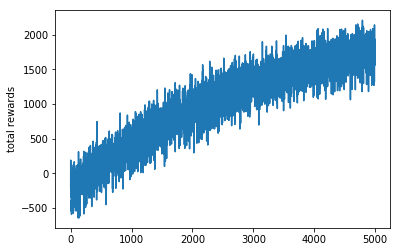

In [13]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [14]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-219.11, -146.87, -75.15, 21.84, 81.24, 105.2, 197.18, 247.06, 311.91, 365.35, 457.11, 470.23, 549.26, 613.66, 664.72, 703.2, 812.42, 827.98, 831.19, 855.74, 927.45, 962.11, 985.68, 1045.19, 1105.85, 1154.9, 1210.34, 1217.01, 1272.38, 1292.5, 1284.81, 1315.02, 1359.77, 1385.16, 1409.15, 1480.54, 1470.93, 1503.57, 1529.66, 1569.64, 1574.06, 1623.57, 1586.69, 1613.73, 1630.62, 1686.74, 1699.7, 1732.75, 1721.79, 1764.45]


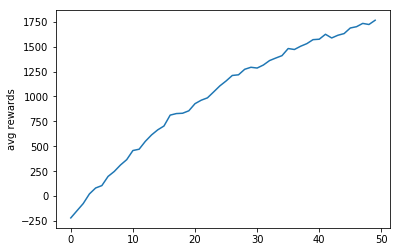

In [15]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

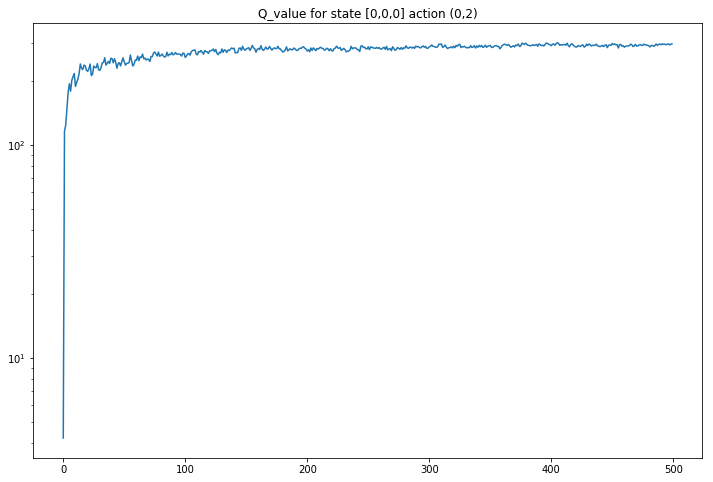

In [16]:
plt.figure(0, figsize=(12,8))
plt.title('Q_value for state [0,0,0] action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [17]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0003*i))

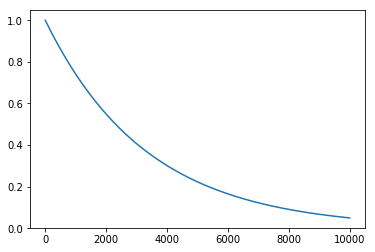

In [18]:
plt.plot(time, epsilon)
plt.show()